In [372]:
import pandas as pd
from zipfile import ZipFile
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np

In [6]:
zip_name = "lastfm-dataset-1K.zip"
with ZipFile(zip_name, 'r') as z:
    folder = "lastfm-dataset-1K/"

    #Read song csv
    song_file = folder +"userid-timestamp-artid-artname-traid-traname.tsv"
    songs = pd.read_csv(z.open(song_file), sep='\t', error_bad_lines=False, 
                    header=None, parse_dates=[1], 
                    names=['user_id', 'timestamp', 'artist_id', 'artist_name', 
                    'track_id', 'track_name'],
                    dtype={0:'category', 2:'category',3:'category',4:'category',5:'category'})

In [289]:
songs.head()

,user_id,timestamp,artist_id,artist_name,track_id,track_name
0,user_000001,2009-05-04 23:08:57+00:00,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04 13:54:10+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04 13:52:04+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04 13:42:52+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04 13:42:11+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)


In [391]:
users = songs.user_id.unique()[:10]
sample = songs[songs.user_id.isin(users)]

In [392]:
def get_embeddings(df, min_count=5):
    df = df.sort_values("timestamp")
    df = df[~df.track_name.isna()]
    df["song_id"]= df.artist_name.cat.codes.astype("int64") * df.track_name.nunique() \
                        + df.track_name.cat.codes
    print(f"Number of entries: {len(sample)}")
    assert len(df.query("song_id < 0")) == 0 #Check underflow
    
    document = df.groupby("user_id").agg(sentences=("song_id", list))
    model = Word2Vec(document.sentences.values, min_count=min_count)
    
    emb_vectors = {}
    for n in model.wv.index_to_key:
        emb_vectors[n] = model.wv[n]
    print(f"Number of song embeddings: {len(emb_vectors)}")
    return emb_vectors

In [393]:
get_embeddings(sample)

Number of entries: 212886
Number of song embeddings: 9904


{71493457: array([ 1.2966584 ,  1.0667685 ,  0.20166852, -1.2580452 , -0.26914656,
         1.4507527 ,  1.1718507 , -1.3112574 , -0.25251225, -1.0825719 ,
        -0.7092495 ,  1.689444  ,  1.5626986 , -1.3805854 , -1.1847935 ,
         1.2620068 ,  2.3534443 ,  2.0375025 , -0.12562332,  1.639928  ,
         1.1718297 ,  0.5192175 , -0.1661586 , -0.56003183,  0.02237052,
         0.49357957, -2.0213952 , -0.85273045,  2.684876  , -0.7985152 ,
         0.6459114 , -0.511625  ,  1.3863369 , -1.075691  , -0.5921504 ,
        -1.0426966 , -0.9324076 ,  1.3951311 , -0.9376018 ,  1.4287275 ,
         0.8039446 ,  0.4042843 , -1.181181  , -2.1295257 , -1.7750015 ,
         2.1748211 ,  0.75891197, -3.2199306 ,  1.3453165 , -0.6541567 ,
        -1.813805  , -0.9387645 ,  3.095747  ,  0.30783126,  0.606665  ,
        -0.04059649, -0.4293453 , -0.74158424,  0.8063964 , -0.19812375,
         0.50423306, -1.8297728 ,  1.2382928 , -0.45161286,  0.38895676,
         0.7125254 ,  0.96545047, -1.0905

In [376]:
len(sample)

19098862

In [377]:
sample.head()

,user_id,timestamp,artist_id,artist_name,track_id,track_name
7558604,user_000391,2005-02-14 00:00:07+00:00,fbd86487-ccb5-4a57-a860-cc3d360b5115,Starsailor,6b4977f4-3c7a-492a-af61-1e877fa66f52,Love Is Here
16881016,user_000871,2005-02-14 00:00:38+00:00,b3a6ebdf-4ee6-4ec0-912c-be03ade6c833,Sui Generis,9ecc2ab3-7294-43ad-bdeb-f51388a7a6e0,Rasguña Las Piedras
13492631,user_000709,2005-02-14 00:01:44+00:00,b4d32cff-f19e-455f-86c4-f347d824ca61,Eurythmics,1d0f1ea5-0a92-4578-a7e7-3f2a7129da61,Love Is A Stranger
5577102,user_000285,2005-02-14 00:02:10+00:00,95e1ead9-4d31-4808-a7ac-32c3614c116b,The Killers,46909ba9-46c7-461e-a2ef-280eacd550e4,Jenny Was A Friend Of Mine
2859034,user_000142,2005-02-14 00:02:40+00:00,51086134-0896-4c00-b54a-c5c37aeaf2bf,Anton Maiden,14025355-94c2-4e9b-b63f-c16cab9e8086,Revelations


In [378]:
sample = sample[~sample.track_name.isna()]

In [379]:
#TODO merge track names with the same track id

In [380]:
sample["song_id"]= sample.artist_name.cat.codes.astype("int64") * songs.track_name.nunique() \
                        + sample.track_name.cat.codes

In [381]:
assert len(sample.query("song_id < 0")) == 0

In [382]:
sample.head()

,user_id,timestamp,artist_id,artist_name,track_id,track_name,song_id
7558604,user_000391,2005-02-14 00:00:07+00:00,fbd86487-ccb5-4a57-a860-cc3d360b5115,Starsailor,6b4977f4-3c7a-492a-af61-1e877fa66f52,Love Is Here,4115113004
16881016,user_000871,2005-02-14 00:00:38+00:00,b3a6ebdf-4ee6-4ec0-912c-be03ade6c833,Sui Generis,9ecc2ab3-7294-43ad-bdeb-f51388a7a6e0,Rasguña Las Piedras,80909156645
13492631,user_000709,2005-02-14 00:01:44+00:00,b4d32cff-f19e-455f-86c4-f347d824ca61,Eurythmics,1d0f1ea5-0a92-4578-a7e7-3f2a7129da61,Love Is A Stranger,1559230142
5577102,user_000285,2005-02-14 00:02:10+00:00,95e1ead9-4d31-4808-a7ac-32c3614c116b,The Killers,46909ba9-46c7-461e-a2ef-280eacd550e4,Jenny Was A Friend Of Mine,4531122533
2859034,user_000142,2005-02-14 00:02:40+00:00,51086134-0896-4c00-b54a-c5c37aeaf2bf,Anton Maiden,14025355-94c2-4e9b-b63f-c16cab9e8086,Revelations,5527952383


In [383]:
#Single user version
# document = pd.DataFrame(sample.groupby(['user_id'])['song_id'].apply(list)).loc["user_000131"]
# model = Word2Vec(document.values, min_count=5)

In [384]:
document = sample.groupby("user_id").agg(sentences=("song_id", list))
model = Word2Vec(document.sentences.values, min_count=5)

In [385]:
emb_vectors = {}
for n in model.wv.index_to_key:
    emb_vectors[n] = model.wv[n]
print(len(emb_vectors))

527552


In [386]:
top10_artists = list(sample[sample.song_id.isin(emb_vectors.keys())].artist_name.value_counts()\
        .to_frame().head(10).index.codes)

In [364]:
# colors = ['rosybrown', 'firebrick', 'deeppink', 'orange', 'goldenrod', 'yellow',\
#           'olivedrab', 'lime', 'aquamarine', 'dodgerblue', \
#           'blueviolet', 'mangenta', 'lightsalmon']
# sample["color"] = '#00000000'
# for i, artist in enumerate(top10_artists):
#     sample.color.where(sample.artist_name.cat.codes != artist, colors[i], inplace=True)
    
# min_count_df = pd.DataFrame(data=emb_vectors.keys(), columns=["song_id"])

# plot_colors = pd.merge(min_count_df, sample[['song_id', 'color']].drop_duplicates(),
#             how='left', left_on='song_id', right_on='song_id').color.values

In [387]:
# sample["top_artist"] = 'others'
# for i, artist in enumerate(top10_artists):
#     sample.top_artist.where(sample.artist_name.cat.codes != artist, sample.artist_name, inplace=True)
    
min_count_df = pd.DataFrame(data=emb_vectors.keys(), columns=["song_id"])

plot_colors = pd.merge(min_count_df, sample[['song_id', 'top_artist']].drop_duplicates(),
            how='left', left_on='song_id', right_on='song_id').top_artist.values

In [323]:
plot_colors = pd.merge(min_count_df, sample[['song_id', 'color']].drop_duplicates(),
            how='left', left_on='song_id', right_on='song_id').color.values

In [388]:
from sklearn.decomposition import PCA
import plotly.express as px

def plot_embeddings_2D(emb_vectors):
    
    # apply PCA
    sg_df = pd.DataFrame(emb_vectors).T
    pca = PCA(n_components=2)
    components = pca.fit_transform(sg_df)
    # plot the vectors
#     fig = px.scatter(components, x=0, y=1, color=sg_df.index)
#     fig.show()
    x, y = components[0], components[1]

    fig, ax = plt.subplots(figsize=(15, 8))
    plot_df = pd.DataFrame(data=components)
    plot_df['top_artist'] = plot_colors
    plot_df = plot_df.query("top_artist != 'others'")
    sns.scatterplot(data=plot_df, x=0, y=1, hue="top_artist")
#     ax.scatter(x, y, c=plot_colors)
#     plt.legend(top10_artists)
        
        
#     for i, term in enumerate(terms):
#         ax.annotate(term, (x[i], y[i]))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

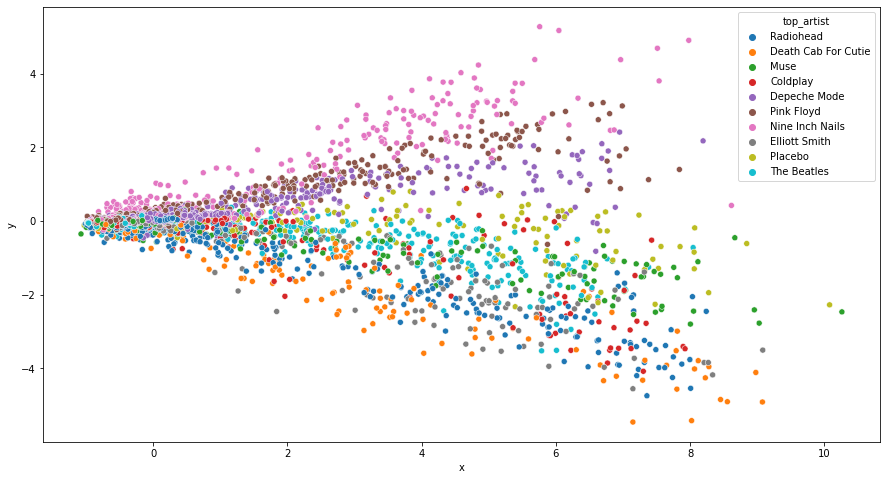

In [389]:
plot_embeddings_2D(emb_vectors)

In [373]:
np.unique(plot_colors)

array(['Britney Spears', 'Dir En Grey', 'Johnny Cash', 'Kanye West',
       'Mando Diao', 'Muse', 'Nine Inch Nails', 'Radiohead',
       'The Beatles', 'others', 'ムック'], dtype=object)